<h1><center><b>PREDICCIÓN DE LLUVIAS PARA EL DIA DE MAÑANA</b></center></h1>
<h3><center><b>MACHINE LEARNING</b></center></h3>


<p align="justify">
Con el objetivo de encontrar un modelo capaz de predecir si va a llover en el dia de mañana en diferentes ciudades (con estaciones climaticas) en australia, a continuación se presenta el desarrollo de un modelo de regresión logística para estimar la variable *RainTomorrow* de nuestro dataset *weatherAUS.csv*.  Este Dataset, cuenta con las observaciones climaticas durante 10 años de numerosas estaciones distribuidas en ciudades a lo largo de Australia. <br>
Una consideración que se contemplo fue excluir de nuestro dataset la variable RISK_MM debido a que esta representa la cantidad de lluvia en milimetros para el dia siguiente. De tal manera que bastaba con tener un valor mayor a cero para saber que si ibamos a tener precipitaciones al dia siguiente (lluvia, llovisna, granizo y nieve). Siendo así, debido a su relación directa con nuestra variable objetivo y a que contiene información sobre el futuro, se optó por no considerarla. 

<font color=”blue” size="2"> Para verificar el funcionamiento del proyecto por favor cargar el archivo weatherAUS.csv, para esto pueden utilizar la siguiente celda   </font>

In [ ]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving weatherAUS.csv to weatherAUS.csv


<font color=”blue” size="2"> Setup para el funcionamiento </font>

In [ ]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
import math
%matplotlib inline

<p align="justify">
En vista de que el dataset que se esta utilizando tiene variables numéricas y también categóricas, se procede a preprocesar esos datos, de esta forma, se cambian los "Yes" y "No" por 1 o 0. De igual forma, se crean distintas variables correspondientes a las direcciones del viento y la ciudad de la cual se tomaron los datos. Todos los valores "N/A" son reemplazados por 0.


In [ ]:
dataset = pd.read_csv('/content/weatherAUS.csv')

dataset['RainToday']  = dataset['RainToday'].map({'Yes': 1, 'No': 0})
dataset['RainTomorrow']  = dataset['RainTomorrow'].map({'Yes': 1, 'No': 0})
dataset = dataset.fillna(0)#method='ffill'


###################################################################
#Estas son variables categoricas que se analizarón. 
#Para poder incluirlas correctamente en nuetro módelo 
#se descomponieron en columnas de unos y ceros, una columna por cada 
#  valor que se presentaba
####################################################################


WGD = pd.get_dummies(dataset[['WindGustDir']])
WGD9 = pd.get_dummies(dataset[['WindDir9am']])
WGD3 = pd.get_dummies(dataset[['WindDir3pm']])
City = pd.get_dummies(dataset[['Location']])

A continuación, se muestran las variables que tenemos en nuestro dataset


In [ ]:
dataset.head(1)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,0.0,0.0,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0.0,0.0,0


In [ ]:
dataset.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')

<p align="justify">
Con el fin de seguir con el preprocesamiento de los datos, se plantea estandarizar todas las variables numéricas. <br> 
<p align="justify">
Al estandarzar los datos vamos a obtener una distribución mucho mas uniforme con media 0 y desviación estandar 1 (nuestros datos se van a similar mas a una distribucion normal estandar como puede ser una gaussiana con media 0 y varianza unitaria). Realizar este paso nos permite comparar los datos de una mejor manera cuando estos en un principio cuentan con escalas y unidades diferentes (como es el caso de nuestro dataset). Realizar esto, a su vez puede solucionar problemas de optimización a los cuales se enfrenta nuestro modelo. Este procedimiento se realiza de forma independiente por cada una de las variables que nosotros tenemos bajo la siguiente formula:


$z=\frac{(x_{i}-\mu )}{\sigma}$


<p align="justify">
Aparte de esto, para tratar las diferentes variables categóricas, se creo una variable por cada posible opción disponible en la columna, creando así 16 variables referentes a las direcciones del viento, 16 variables referentes a la dirección del viento a las 9 am, 16 variables referentes a la dirección del viento a las 3 pm y 49 variables de la locación, una para cada ciudad de la base de datos.

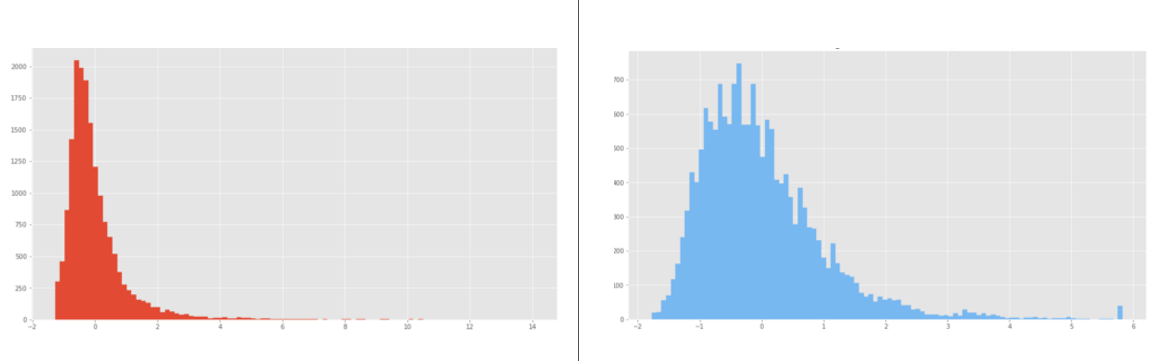

In [ ]:
###################################################################
#Tras realizar diferentes pruebas estas son las columnas de entrenamiento
# que se definieron con las cuales obtuvimos una mayor precisión por 
# parte de nuestro modelo.
####################################################################


#dataset2=dataset[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
#       'Sunshine', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
#       'Temp3pm','RISK_MM','RainTomorrow']]

dataset2 = dataset[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 
       'Cloud9am', 'Cloud3pm', 'Temp9am','Temp3pm']]


# Estandarización

df_scaled = StandardScaler() 
df_scaled = pd.DataFrame(df_scaled.fit_transform(dataset2), columns = dataset2.columns)

#Concatenación de las variables categoricas que analizamos

df_scaled= pd.concat([df_scaled, WGD],axis=1)
df_scaled= pd.concat([df_scaled, WGD9],axis=1)
df_scaled= pd.concat([df_scaled, WGD3],axis=1)
df_scaled= pd.concat([df_scaled, City],axis=1)
df_scaled= pd.concat([df_scaled, dataset['RainToday']],axis=1)


In [ ]:
df_scaled.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,WindGustDir_0,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_0,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,...,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,RainToday
count,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,1.421930e+05,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.00000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,...,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,1.554528e-15,1.798808e-15,-2.226648e-14,-5.535758e-14,-8.103569e-14,-1.495874e-14,2.002066e-14,3.437844e-15,-1.401909e-16,-6.916202e-16,-1.312799e-14,1.514791e-14,-8.717357e-15,6.258071e-15,-4.986450e-15,1.813602e-15,0.065615,0.063794,0.056205,0.051374,0.063526,0.049651,0.045241,0.046142,0.056283,0.062936,0.065467,0.063245,0.060552,0.061867,0.06878,0.056726,0.062598,0.070418,0.063463,0.054398,0.053153,0.080123,0.052935,0.055896,...,0.021014,0.020768,0.020697,0.022448,0.020957,0.022420,0.010964,0.021295,0.017125,0.021161,0.021147,0.020071,0.021309,0.020444,0.020782,0.011034,0.020599,0.020845,0.021112,0.019424,0.020845,0.022455,0.021161,0.021070,0.020753,0.021098,0.020782,0.023468,0.021133,0.021330,0.021084,0.010697,0.020929,0.019825,0.021091,0.017954,0.020761,0.020979,0.021028,0.221213
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.247609,0.244386,0.230319,0.220760,0.243908,0.217223,0.207834,0.209792,0.230468,0.242848,0.247350,0.243404,0.238507,0.240914,0.25308,0.231319,0.242239,0.255852,0.243795,0.226802,0.224339,0.271485,0.223905,0.229721,...,0.143430,0.142606,0.142369,0.148137,0.143242,0.148046,0.104134,0.144366,0.129736,0.143923,0.143876,0.140245,0.144413,0.141514,0.142653,0.104463,0.142037,0.142865,0.143759,0.138011,0.142865,0.148160,0.143923,0.143618,0.142558,0.143712,0.142653,0.151385,0.143829,0.144483,0.143665,0.102871,0.143148,0.139400,0.143688,0.132786,0.142582,0.143313,0.143477,0.415065
min,-3.203435e+00,-3.888

In [ ]:
df_scaled.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm',
       ...
       'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga',
       'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown',
       'Location_Witchcliffe', 'Location_Wollongong', 'Location_Woomera',
       'RainToday'],
      dtype='object', length=117)

In [ ]:
df_scaled.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,WindGustDir_0,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_0,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,...,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,RainToday
0,0.196908,-0.038109,-0.204920,-0.751043,-0.850637,0.402991,0.684660,0.628828,0.147682,-1.276568,0.297764,0.303160,1.671631,-0.883606,0.003099,0.070596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,-0.734693,0.267670,-0.276125,-0.751043,-0.850637,0.402991,-1.102162,0.408463,-1.174810,-1.140645,0.307322,0.305475,-0.881842,-0.883606,0.048475,0.404520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,0.119275,0.351064,-0.276125,-0.751043,-0.850637,0.524696,0.572984,0.849194,-1.468697,-0.914107,0.297435,0.308451,-0.881842,-0.227877,0.623233,0.257594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,-0.455212,0.670742,-0.276125,-0.751043,-0.850637,-0.814062,-0.320427,-1.023912,-1.125829,-1.548413,0.330394,0.322011,-0.881842,-0.883606,0.184602,0.698373,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,0.833502,1.268400,-0.157450,-0.751043,-0.850637,0.220433,-0.767133,0.188098,0.686476,-0.778184,0.307982,0.299522,1.352446,1.739310,0.139226,1.125796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


<p align="justify">
Debido a que nuestra variable objetivo toma valores dentro de un conjunto finito y mas especificamente 1 o 0 / Yes o No dependiendo de si va a llover o no al dia siguiente, se procedio a impementar un modelo de regresión logística, con el fin de establecer la relación entra la probabilidad de que ocurra este suceso, dado un conjunto de variables independientes (las mediciones de nuestro Dataset), esta relación se puede ver de esta manera

$Pr(Y=1|x_{1},x_{2},... )=\frac{1}{1+exp(-a-\beta_{1}x_{1}-\beta_{1}x_{1}-...))}$

o

$log(\frac{Pr(Y=1|x)}{1-Pr(Y=1|x)})= a +\beta_{1}x_{1}+\beta_{1}x_{1}+...$




In [ ]:
Xcol = df_scaled
X = Xcol.values

y = dataset['RainTomorrow'].values

<p align="justify">
Seguido a esto, procedemos a separar el 80% nuestros datos en un conjunto de entrenamiento y uno de prueba, con el fin de poder entrenar y a su ves probar y estimar la eficiencia de nuestra regresión

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<p align="justify">
Despues se procede a entrenar nuestro modelo, con ayuda de la libreria Scikit-Learn, la cual se encarga de determinar los coeficientes mas optimos de nuestro modelo. Es importante resaltar, que el valor del coeficiente al tratarse del modelo lineal representado previamente nos indica el peso o que tanto influye una variable en nuestra predicción de si va a llover o no al dia siguiente y cuales son las que tiene una mayor relevancia. Cabe destacar que inicialmente para la cantidad de variables utilizadas se tuvo que aumentar el número por defecto de iteraciones para que el modelo lograra converger.

In [ ]:
regressor = LogisticRegression(max_iter=300)  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame((regressor.coef_).transpose(),Xcol.columns, columns=['Coef'])  
coeff_df

,Coef
MinTemp,0.439004
MaxTemp,0.407546
Rainfall,0.112377
Evaporation,0.013555
Sunshine,-0.443195
...,...
Location_Williamtown,0.202651
Location_Witchcliffe,0.651544
Location_Wollongong,-1.210119
Location_Woomera,-0.455809


<p align="justify">
Una vez tenemos los coeficientes de nuestro modelo, se realiza una prueba directa sobre los datos de testeo, para poder evidenciar que tan acertadas estan siendo las predicciones. Algo que se puede evidenciar tanto de manera grafica como con el uso de algoritmos de desempeño.   

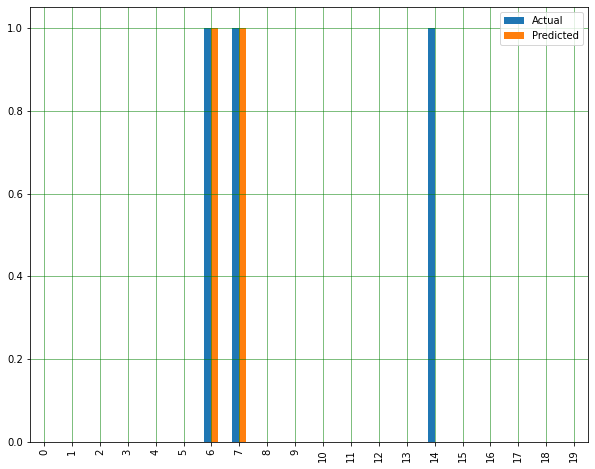

In [ ]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [ ]:
Y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': Y_pred.flatten()})
df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
28434,0,0
28435,0,0
28436,0,0
28437,0,0


Por último, se procede a determinar los indicadores de desempeño de nuestro modelo, los cuales son:


In [ ]:
print('Porcentaje de exactitud:', round(precision_score(y_test, Y_pred)*100,3),'%')  

Porcentaje de exactitud: 71.679 %


# Análisis

<p align="justify">
Para tener un indicador de desempeño que más se ajuste a los interéses de nuestro reto, utilizamos la métrica de precisión_score de sklearn. Debido a que este indicador nos permite estimar la cantidad de prediciones correctas que tenemos. Un 100% indica que predecimos correctamente si iba a llover o no la dia siguiente.

$ Pcorrectas / (Pcorrectas + Pincorrectas)$



<p align="justify">
Si analizamos todas las columnas númericas de nuestro dataset, junto con las columnas categoricas (ubicación, y los cambios de dirección en el viento) llegamos a tener un modelo con una presición del 72.694 %.

<p align="justify">
Si lo miramos se manera general, esto quiere decir que a lo largo de 10 años o 3650 dias vamos a tener un estimado de predicciones erroneas equivalentes a 803 dias o 2.2 años, en alguna de las diferentes ciudades.

<p align="justify">
Debido a la cantidad de variables que estamos considerando fue necesario aumentar nuestro número máximo de iteraciones para que nuestro modelo pudiera converger. Cuando se realizó el modelo con casi todas las variables, pero, sin estandarizar las variables numéricas, al final no se llegaba a ninguna convergencia, pero una vez estas se estandarizaron ya era posible converger.


# **Modelo 2**




<p align="justify">
Para evidenciar el peso que tiene cada variable en nuestro modelo, (debido a que es un modelo lineal la variable con un coeficiente mayor absoluto, va a ser la mas influyente en nuestra predicción). Para esto se fueron eliminando las variables que tenien los menores coeicientes progresivamente, hasta quedarnos con: <br>

- MinTemp - MaxTemp - Rainfall - Evaporation - Sunshine - WindGustSpeed - WindSpeed9am - WindSpeed3pm - Humidity9am - Humidity3pm - Pressure9am - Pressure3pm - Cloud9am - Cloud3pm - Temp9am - Temp3pm <br><br>
De estas la variable con el mayor coeficiente y, por ende, la de mayor relevancia para nuestra predicción es la humedad que se presento a las 3pm.

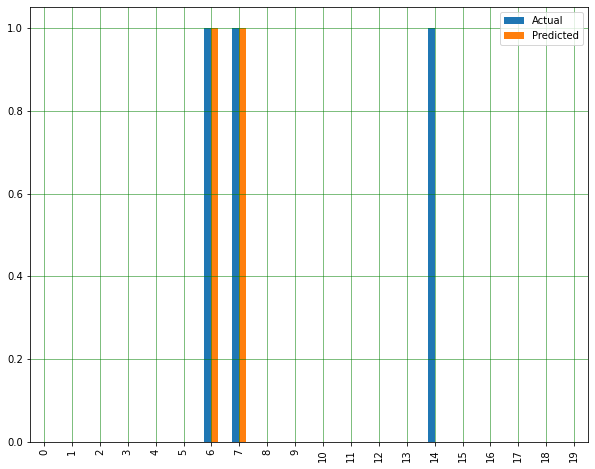

,Coef
MinTemp,0.373628
MaxTemp,0.414499
Rainfall,0.255572
Evaporation,0.005975
Sunshine,-0.323019
WindGustSpeed,0.565248
WindSpeed9am,-0.082718
WindSpeed3pm,-0.130421
Humidity9am,0.040034
Humidity3pm,0.899613


In [ ]:
datasetA = pd.read_csv('/content/weatherAUS.csv')

datasetA['RainToday']  = datasetA['RainToday'].map({'Yes': 1, 'No': 0})
datasetA['RainTomorrow']  = datasetA['RainTomorrow'].map({'Yes': 1, 'No': 0})
datasetA = datasetA.fillna(0)#method='ffill'


dataset2A = datasetA[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 
       'Cloud9am', 'Cloud3pm', 'Temp9am','Temp3pm']]


# Estandarización

df_scaledA = StandardScaler() 
df_scaledA = pd.DataFrame(df_scaledA.fit_transform(dataset2A), columns = dataset2A.columns)


XcolA = df_scaledA
XA = XcolA.values

yA = datasetA['RainTomorrow'].values

X_train, X_test, y_train, y_test = train_test_split(XA, yA, test_size=0.2, random_state=0)

regressorA = LogisticRegression(max_iter=50)  
regressorA.fit(X_train, y_train)

Y_pred = regressorA.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': Y_pred.flatten()})
df

y_pred = regressorA.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(20)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


coeff_df = pd.DataFrame((regressorA.coef_).transpose(),XcolA.columns, columns=['Coef'])  
coeff_df


In [ ]:
print('Porcentaje de exactitud:', round(precision_score(y_test, Y_pred)*100,3),'%')  

Porcentaje de exactitud: 71.679 %


<p align="justify">
En este caso se obtuvo una presición del 71,679% pero logramos llegar a una convergencia más rápida, se pasó de 300 iteraciones (primer modelo) a unas 50 aproximadamente (segundo modelo) y pasamos de utilizar 117 variables a usar tan solo 16, a cambio de un -1.05% de precisión, lo cual equivaldría a errar 38 días adicionales en un período de 10 años, pero tenemos un módelo menos complejo. 

<p align="justify">
En base a este análisis realizado, se concluye que si bien el primer modelo presenta una mayor exactitud para acertar cuando lloverá al día siguiente y cuando no, se tiene que este modelo es más complejo y requiere de una mayor cantidad de datos haciendolo menos eficiente computacionalmente frente al segundo modelo. Por otro lado, este modelo predice cuando lloverá en Australia, como trabajo futuro, se propone dividir el *dataset* según la ciudad y crear un modelo de predicción de lluvias para cada locación. Según lo anterior, la predicción pudiera llegar a ser más útil debido a que sería más localizado y relevante para los ciudadanos de cada ciudad.

.

.

.